# A Dog Identification

## An Application of Convolutional Neural Networks for Dog Identification 

## Completed as a part of the Deep Learning Nanodegree through Udacity

---
### Our Objective 

In this notebook, we will walk through the steps of prototyping an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  For example, with the given image below we might see as an output:  

![Sample Dog Output](images/sample_dog_output.png)

### The Roadmap

We break the notebook into the separate components that comprise the application.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Writing the Algorithm
* [Step 6](#step6): Testing our Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

C:\Anaconda3\envs\bayes\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13234 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


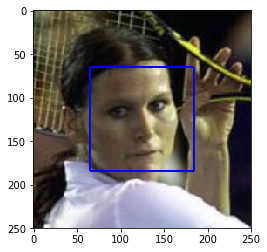

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[6])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Evaluating the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You see that our algorithm falls short of this goal, but still gives acceptable performance.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

print(f'{100*np.array([face_detector(file) for file in human_files_short]).mean()}% of the human files flagged as having faces')
print(f'{100*np.array([face_detector(file) for file in dog_files_short]).mean()}% of the dog files were flagged as having faces')

98.0% of the human files flagged as having faces
12.0% of the dog files were flagged as having faces


As we'll see in our application later, this approach to human detection leads to many false negatives.  We can also see just from the calculation above that this approach would also lead to false positives for roughly 12% of dogs.  So, no I wouldn't say that this is a very robust method for human detection.  

One simple alternative would be to take advantage of the other classes that available from imagenet.  In addition to all of the dogs, there classes which correspond to pictures with people in them which.  We would then probably want to mine a simple dataset containing people and dogs which the model distinguishes between the two fo them.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In the same way we did for human faces, we evaluate our dog detector.

In [10]:
print(f'% Humans with dog detected: {np.array([dog_detector(human) for human in human_files_short]).mean()}')
print(f'% Dogs with dog detected: {np.array([dog_detector(dog) for dog in dog_files_short]).mean()}')

% Humans with dog detected: 0.02
% Dogs with dog detected: 1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds.  We start by doing so by scratch as an exercise.  In Step 5 of this notebook, we will actually use transfer learning to create a CNN that attains greatly improved accuracy.



### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255 because neural networks need inputs that are close to 0.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████| 836/836 [00:05<00:00, 154.19it/s]


### Model Architecture

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

def conv_block(model, filters, kernel, dropout=0, input_shape=None):
    if input_shape is not None:
        model.add(Conv2D(filters=filters, 
                 kernel_size=kernel,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=input_shape))
    else:
        model.add(Conv2D(filters=filters, 
                 kernel_size=kernel,
                 strides=1,
                 padding='same',
                 activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=2,
                       padding='same'))
    return model

model = Sequential()

model = conv_block(model, 32, 5, dropout=0.2, input_shape=(224, 224, 3))
model = conv_block(model, 64, 4, dropout=0.2)
model = conv_block(model, 128, 3, dropout=0.2)
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='relu'))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
__________

### Compile the Model

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Train the Model

We train the model below and use model checkpointing to save the model that attains the best validation loss.

In [16]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 41s 6ms/step - loss: 4.8868 - acc: 0.0105 - val_loss: 4.8766 - val_acc: 0.0108

Epoch 00001: val_loss improved from inf to 4.87658, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 40s 6ms/step - loss: 4.8730 - acc: 0.0100 - val_loss: 4.8705 - val_acc: 0.0108

Epoch 00002: val_loss improved from 4.87658 to 4.87047, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 40s 6ms/step - loss: 4.8695 - acc: 0.0112 - val_loss: 4.8708 - val_acc: 0.0108

Epoch 00003: val_loss did not improve from 4.87047
Epoch 4/10
6680/6680 [==============================] - 40s 6ms/step - loss: 4.8673 - acc: 0.0121 - val_loss: 4.8582 - val_acc: 0.0120

Epoch 00004: val_loss improved from 4.87047 to 4.85824, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/10
668

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Checking the accuracy, we can see that we are learning (random guessing would be < 1% accuracy), but very slowly.  To get a jumpstart, we'll instead take a look at implementing transfer learning. 

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.9904%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  One way to help speed of training time is to make use of bottleneck features.  Because we are using a pre-trained model, ResNet-50 in our case, we won't actually apply backpropogation to those layers.  As a result we can speed up our training a ton by passing all of our data through ResNet-50's layers, all the up until we are intending to add on our own layers that will actually get trained.  

This creates a dataset which we can now train our our much smaller netowrk on, but still get all the benefits of transfer learning. Once we calulated the bottleneck_features, we stored them in the data/bottleneck_feature folder. 

In [19]:
def extract_res50_features():
    bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
    train_Res50 = bottleneck_features['train']
    valid_Res50 = bottleneck_features['valid']
    test_Res50 = bottleneck_features['test']
    return train_Res50, valid_Res50, test_Res50
train_Res50, valid_Res50, test_Res50 = extract_res50_features()

### Model Architecture

As you can see, we don't need to add many layers to our model thanks to the bottlenecked features. 

In [26]:
Res50_model = Sequential()
Res50_model.add(GlobalAveragePooling2D(input_shape=train_Res50.shape[1:]))
Res50_model.add(Dense(500, activation='relu'))
Res50_model.add(Dropout(0.3))
Res50_model.add(Dense(133, activation='softmax'))

Res50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               66633     
Total params: 1,091,133
Trainable params: 1,091,133
Non-trainable params: 0
_________________________________________________________________


In [27]:
Res50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [28]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Res50.hdf5', 
                               verbose=1, save_best_only=True)

Res50_model.fit(train_Res50, train_targets, 
          validation_data=(valid_Res50, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer], verbose=0)


Epoch 00001: val_loss improved from inf to 0.90009, saving model to saved_models/weights.best.Res50.hdf5

Epoch 00002: val_loss improved from 0.90009 to 0.69252, saving model to saved_models/weights.best.Res50.hdf5

Epoch 00003: val_loss did not improve from 0.69252

Epoch 00004: val_loss did not improve from 0.69252

Epoch 00005: val_loss did not improve from 0.69252


### Load the Model with the Best Validation Loss

In [24]:
### Loading the model weights with the best validation loss.
Res50_model.load_weights('saved_models/weights.best.Res50.hdf5')

### Test the Model

As you can see, we got much more impressive results through transfer learning.  With just 5 epochs of training, we attained nearly 80% accuracy on this dataset.

In [30]:
### Calculate classification accuracy on the test dataset.
Res50_predictions = [np.argmax(Res50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Res50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Res50_predictions)==np.argmax(test_targets, axis=1))/len(Res50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.4258%


### Predict Dog Breed with the Model

We now need the ability to make predictions with our model.  The first step is simply to have Resnet50 make a prediction, excluding the last maxpooling and dense layers.  Then our model will make a prediction about the dog breed.  

In [31]:
from extract_bottleneck_features import *

def Res50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Res50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [32]:
for file in human_files_short[:5]:
    print(Res50_predict_breed(file))

\069.French_bulldog
\069.French_bulldog
\132.Xoloitzcuintli
\014.Basenji
\048.Chihuahua


---
<a id='step5'></a>
## Step 5: Writing the Algorithm

We'll now put it all together in a function which will identify if a human or dog is in a photo, and classify the photo as a dog breed. 

In [33]:
def Res50_predict_breed(img_path):
    # Use our dog and face detector to determine if our
    # input is human or a dog.  The face (human) detector
    # is more prone to false positives, so we use it second. 
    if dog_detector(img_path):
        print("hello, dog!")
    elif face_detector(img_path):
        print("hello, human!")
    else:
        print("hello, alien creature!")
    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Res50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    name = dog_names[np.argmax(predicted_vector)]
    
    print("You look like a ...")
    print(name)

---
<a id='step6'></a>
## Step 6: Testing Our Algorithm

In this section, we test our application and offer some criticism for how we might improve this application. 

The real weakness in the application currently is the human detector.  As we can see from the example first set of example humans, we can easily identify a human *if* their face is the focus of the shot.  However if the picture contains more than that, say as in the picture of the woman with a python at the bottom, we notice that it fails to identify the subject as human. So, the first improvement would be a proper human detector that might use deep learning instead of the face detector we are currently using.  

I was quite happy with the dog breed model.  It correctly identified the two breeds in the pictures I provided.  Accounting for mixed breeds would be smart for this particular aspect of the applicaiton.

hello, human!


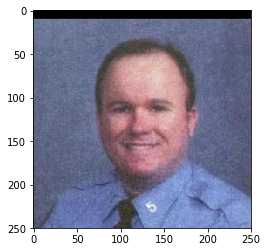

You look like a ...
\127.Silky_terrier
hello, human!


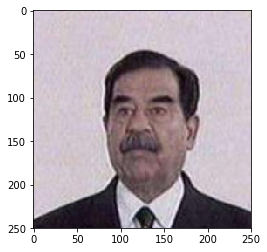

You look like a ...
\132.Xoloitzcuintli
hello, human!


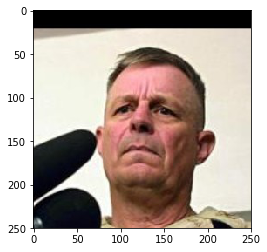

You look like a ...
\132.Xoloitzcuintli
hello, human!


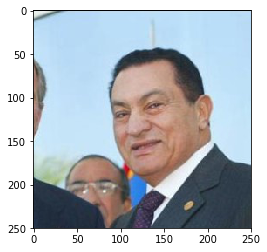

You look like a ...
\127.Silky_terrier
hello, human!


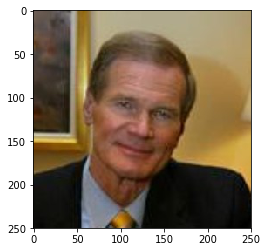

You look like a ...
\127.Silky_terrier


In [65]:
for imfile in human_files_short[:5]:
    Res50_predict_breed(imfile)

hello, human!


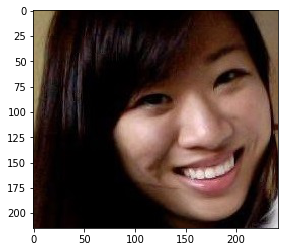

You look like a ...
\017.Bearded_collie
hello, dog!


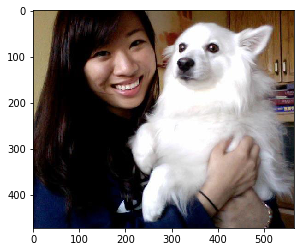

You look like a ...
\006.American_eskimo_dog
hello, alien creature!


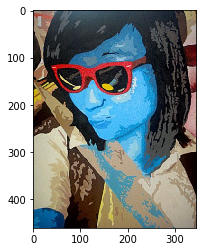

You look like a ...
\057.Dalmatian
hello, alien creature!


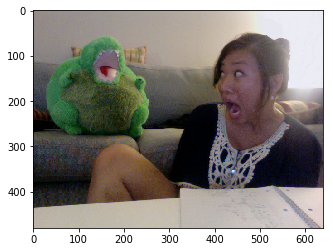

You look like a ...
\112.Nova_scotia_duck_tolling_retriever
hello, dog!


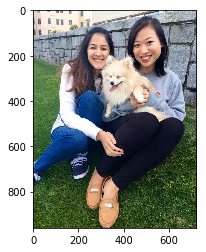

You look like a ...
\123.Pomeranian
hello, alien creature!


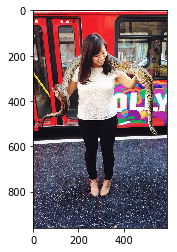

You look like a ...
\124.Poodle


In [65]:
for imfile in np.array(glob("data/test/*")):
    Res50_predict_breed(imfile)